# DECISION TREE

The Wisconsin Breast Cancer Dataset(WBCD) can be found here(https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)

This dataset describes the characteristics of the cell nuclei of various patients with and without breast cancer. The task is to classify a decision tree to predict if a patient has a benign or a malignant tumour based on these features.

Attribute Information:
```
#  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)
```


In [49]:
import pandas as pd
import math

headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.data', na_values='?',    
         header=None, index_col=['ID'], names = headers) 
data = data.reset_index(drop=True)
data = data.fillna(0)
# data.describe()

In [50]:
data = data.to_numpy()
train, test = train_test_split(data, test_size=0.25)

### Implement a decision tree(from scratch using only python data structures) as a class.

In [51]:
training_data = train
def get_uniq_val(input, col=0):
    uniq_val = set()

    for data in input:
        uniq_val.add(data[col])

    return uniq_val

def get_uniq_val_freq(input, col=0):
    uniq_val = get_uniq_val(input, col)

    uniq_val_freq = {}

    for key in uniq_val:
        uniq_val_freq[key] = 0

    for data in input:
        uniq_val_freq[data[col]] += 1

    return uniq_val_freq

def get_class_count(input):
    return get_uniq_val_freq(input, -1)

def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

class que:
    def __init__(self, col, val):
        self.col = col
        self.val = val

    def get_ans(self, input_row):
        val = input_row[self.col]

        if is_numeric(val) == True:
            return val >= self.val
        else:
            return val == self.val

    def __str__(self):
        return "Is" + str(headers[self.col]) + ">=" + str(self.val) +":"

def do_partition_on_que(input, question):
    true_data = []
    false_data = []

    for data in input:
        if question.get_ans(data) == True:
            true_data.append(data)
        else:
            false_data.append(data)

    return true_data, false_data

def cal_gini_impurity(input):

    class_count = get_class_count(input)
    impurity = 1

    n = len(input)

    for lable in class_count:
        prob_lable = class_count[lable] / float(n)
        impurity -= (prob_lable ** 2)

    return impurity

def get_gini_info_gain(input, left, right):
    curr_gini = cal_gini_impurity(input)

    prob = float(len(left)) / (len(left) + len(right))
    return curr_gini - ( prob * cal_gini_impurity(left) )- ( (1 - prob) * cal_gini_impurity(right) )

def cal_entopy_impurity(input):

    class_count = get_class_count(input)
    impurity = 0

    n = len(input)

    for lable in class_count:
        prob_lable = class_count[lable] / float(n)
        lbase2 = math.log2(prob_lable)

        impurity -= (prob_lable * lbase2)

    return impurity

def get_entropy_info_gain(input, left, right):
    curr_gini = cal_entopy_impurity(input)

    prob = float(len(left)) / (len(left) + len(right))
    return curr_gini - ( prob * cal_entopy_impurity(left) )- ( (1 - prob) * cal_entopy_impurity(right) )


def cal_miscls_impurity(input):

    class_count = get_class_count(input)
    impurity = 1

    n = len(input)
    prob_list = []

    for lable in class_count:
        prob_lable = class_count[lable] / float(n)
        prob_list.append(prob_lable)

    impurity -= max(prob_list)
    return impurity

def get_miscls_info_gain(input, left, right):
    curr_gini = cal_miscls_impurity(input)

    prob = float(len(left)) / (len(left) + len(right))
    return curr_gini - ( prob * cal_miscls_impurity(left) )- ( (1 - prob) * cal_miscls_impurity(right) )

def get_info_gain(input, left, right, info_gain_type):
    if info_gain_type == 0:
        return get_gini_info_gain(input, left, right)
    elif info_gain_type == 1:
        return get_entropy_info_gain(input, left, right)
    elif info_gain_type == 2:
        return get_miscls_info_gain(input, left, right)
    
    return -1

def get_best_partition(input, info_gain_type):

    col_count = len(input[0]) - 1
    
    best_info_gain = 0
    best_que = None

    for col in range(col_count):

        unique_val = get_uniq_val(input, col)
        for val in unique_val:
            
            question = que(col, val)
            true_data, false_data = do_partition_on_que(input, question)

            if len(true_data) == 0 or len(false_data) == 0:
                continue

            info_gain = get_info_gain(input, true_data, false_data, info_gain_type)
            if info_gain > best_info_gain:
                
                best_info_gain = info_gain
                best_que = question                

    return best_info_gain, best_que

class treenode:
    def __init__(self, que, left, right):
        self.que = que
        self.left = left
        self.right = right

class treeleaf:
    def __init__(self, input):
        self.predictions = get_class_count(input)

def buid_decision_tree(input_training_data, info_gain_type):

    info_gain, question = get_best_partition(input_training_data, info_gain_type)
    if info_gain == 0:
        return treeleaf(input_training_data)

    true_data, false_data = do_partition_on_que(input_training_data, question)

    left = buid_decision_tree(true_data, info_gain_type)
    right = buid_decision_tree(false_data, info_gain_type)

    return treenode(question, left, right)

def print_tree(treenode, space=""):

    if isinstance(treenode, treeleaf):
        print (space , treenode.predictions)
        return

    print (space + str(treenode.que))

    print (space + 'True:')
    print_tree(treenode.left, space + "|  ")

    print (space + 'False:')
    print_tree(treenode.right, space + "|  ")


### Train a decision tree object of the above class on the WBC dataset using misclassification rate, entropy and Gini as the splitting metrics.

### Gini as the splitting matrics

In [52]:
decision_tree_gini = buid_decision_tree(training_data, info_gain_type=0)

### Entropy as the splitting matrics

In [53]:
decision_tree_entopy = buid_decision_tree(training_data, info_gain_type=1)

### Misclassification rate as the splitting matrics

In [54]:
decision_tree_miscls = buid_decision_tree(training_data, info_gain_type=2)

### Report the accuracies in each of the above splitting metrics and give the best result. 

In [55]:
def classify(row, decision_tree):

    if isinstance(decision_tree, treeleaf):
        return decision_tree.predictions

    if decision_tree.que.get_ans(row):
        return classify(row, decision_tree.left)
    else:
        return classify(row, decision_tree.right)

def find_accuracy(testing_data, decision_tree):
    
    false_count = 0
    true_count = 0

    for data_row in testing_data:
        class_prediction = classify(data_row, decision_tree)

        if data_row[-1] in class_prediction:
            true_count += 1
        else:
            false_count += 1
    
    return len(testing_data), true_count, false_count, float(true_count/len(testing_data))

In [56]:
testing_data = test

acc_data = []

total_data, true_count, false_count, accuracy = find_accuracy(testing_data, decision_tree_gini)
acc_data.append(['Gini',total_data, true_count, false_count, accuracy])

total_data, true_count, false_count, accuracy = find_accuracy(testing_data, decision_tree_entopy)
acc_data.append(['Entropy',total_data, true_count, false_count, accuracy])

total_data, true_count, false_count, accuracy = find_accuracy(testing_data, decision_tree_miscls)
acc_data.append(['Mis classification rate',total_data, true_count, false_count, accuracy])

In [57]:
headr = ['Type', 'Total Testing data', 'Correct Prediction', 'Wrong Prediction', 'Accuracy']
print(tabulate(acc_data, headers=headr, tablefmt="fancy_grid"))

╒═════════════════════════╤══════════════════════╤══════════════════════╤════════════════════╤════════════╕
│ Type                    │   Total Testing data │   Correct Prediction │   Wrong Prediction │   Accuracy │
╞═════════════════════════╪══════════════════════╪══════════════════════╪════════════════════╪════════════╡
│ Gini                    │                  175 │                  158 │                 17 │   0.902857 │
├─────────────────────────┼──────────────────────┼──────────────────────┼────────────────────┼────────────┤
│ Entropy                 │                  175 │                  161 │                 14 │   0.92     │
├─────────────────────────┼──────────────────────┼──────────────────────┼────────────────────┼────────────┤
│ Mis classification rate │                  175 │                  167 │                  8 │   0.954286 │
╘═════════════════════════╧══════════════════════╧══════════════════════╧════════════════════╧════════════╛


### Does standardisation and normalisation help in this case? Report

- Ans: No
- Reason: Decision Tree uses rule based approach instead of distance calculation

### Compare your trained model with a model trained by the scikit-learn DecisionTreeClassifier module. Compare accuracies.

In [58]:
import pandas as pd
import math

headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.data', na_values='?',    
         header=None, index_col=['ID'], names = headers) 
data = data.reset_index(drop=True)
data = data.fillna(0)
# data.describe()

In [59]:
X = data.drop(['Diagnosis'], axis=1)
Y = data['Diagnosis']

X = X.to_numpy().astype(np.float)
Y = Y.to_numpy().astype(np.float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier()
tree.fit(X_train, Y_train)

Y_pred = tree.predict(X_test)

acc_data.append(['scikit-learn module', -1, -1, -1, accuracy_score(Y_test, Y_pred)])

In [61]:
headr = ['Type', 'Total Testing data', 'Correct Prediction', 'Wrong Prediction', 'Accuracy']
print(tabulate(acc_data, headers=headr, tablefmt="fancy_grid"))

╒═════════════════════════╤══════════════════════╤══════════════════════╤════════════════════╤════════════╕
│ Type                    │   Total Testing data │   Correct Prediction │   Wrong Prediction │   Accuracy │
╞═════════════════════════╪══════════════════════╪══════════════════════╪════════════════════╪════════════╡
│ Gini                    │                  175 │                  158 │                 17 │   0.902857 │
├─────────────────────────┼──────────────────────┼──────────────────────┼────────────────────┼────────────┤
│ Entropy                 │                  175 │                  161 │                 14 │   0.92     │
├─────────────────────────┼──────────────────────┼──────────────────────┼────────────────────┼────────────┤
│ Mis classification rate │                  175 │                  167 │                  8 │   0.954286 │
├─────────────────────────┼──────────────────────┼──────────────────────┼────────────────────┼────────────┤
│ scikit-learn module     │ 

### Output a depth first traversal of your decision tree in a file named ```outputimp.txt``` respectively in the following format and submit it along with the assignment.


```
<Node classification criteria in words.>
<Branch label>
  ... And so on, recursively.
```
 
For example,
a depth first search traversal for the below decision tree would be:

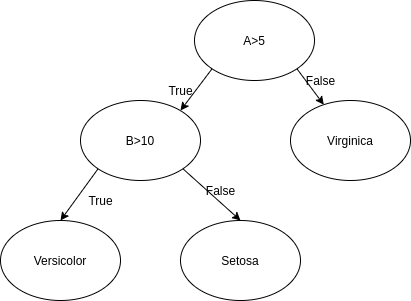
```
Is A>5?
True Branch
  Is B>10?
  True Branch
    Versicolor
  Is B>10?
  False Branch
    Setosa
Is A>5?
False Branch
	Virginica

```




In [62]:
tree_list = []
def save_tree(treenode, filename= 'tree.txt'):
    global tree_list
    
    tree_list = []

    get_tree_as_list(treenode)

    file = open(filename, 'w')
    file.writelines(tree_list)
    file.close()

def get_tree_as_list(treenode, space=""):

    if isinstance(treenode, treeleaf):
        tree_list.append(space + "DIAGNOSIS : " + str(list(treenode.predictions.keys())) + "\n")
        return

    tree_list.append(space + str(treenode.que) + "\n")

    tree_list.append(space + 'True:' + "\n")
    get_tree_as_list(treenode.left, space + "|  ")

    tree_list.append(space + 'False:' + "\n")
    get_tree_as_list(treenode.right, space + "|  ")

### Experiment with removing features that are redundant, highly correlated with other features and report accuracies of the resulting model. Explain your approach.

In [63]:
import pandas as pd
import math

headers = ["ID","CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses","Diagnosis"]
data = pd.read_csv('breast-cancer-wisconsin.data', na_values='?',    
         header=None, index_col=['ID'], names = headers) 
data = data.reset_index(drop=True)
data = data.fillna(0)

In [64]:
from scipy.stats import pearsonr

header_list = ["CT","UCSize","UCShape","MA","SECSize","BN","BC","NN","Mitoses"]
Y = data['Diagnosis'].astype(np.float)

co_relation = []
for hdr in header_list:
    col_data = data[hdr].astype(np.float)

    co_rel, _ = pearsonr(col_data, Y)
    co_relation.append([hdr, 'Diagnosis', co_rel])
    
headr = ['Col-1', 'Col-2', 'Corelation']
print(tabulate(co_relation, headers=headr, tablefmt="fancy_grid"))

╒═════════╤═══════════╤══════════════╕
│ Col-1   │ Col-2     │   Corelation │
╞═════════╪═══════════╪══════════════╡
│ CT      │ Diagnosis │     0.716001 │
├─────────┼───────────┼──────────────┤
│ UCSize  │ Diagnosis │     0.817904 │
├─────────┼───────────┼──────────────┤
│ UCShape │ Diagnosis │     0.818934 │
├─────────┼───────────┼──────────────┤
│ MA      │ Diagnosis │     0.6968   │
├─────────┼───────────┼──────────────┤
│ SECSize │ Diagnosis │     0.682785 │
├─────────┼───────────┼──────────────┤
│ BN      │ Diagnosis │     0.817653 │
├─────────┼───────────┼──────────────┤
│ BC      │ Diagnosis │     0.756616 │
├─────────┼───────────┼──────────────┤
│ NN      │ Diagnosis │     0.712244 │
├─────────┼───────────┼──────────────┤
│ Mitoses │ Diagnosis │     0.42317  │
╘═════════╧═══════════╧══════════════╛


### Report the advantages and disadvantages of decision trees based on the above question.

- Advantages
    - Simple and easy to understand
    - Less data cleaning required
    - used for classification and regression problems
    - can handle continuous and categorical variables
    - Clear Visualization: easily interpreted by humans
    - Less Training Period
    - robust to outliers 
    - can automatically handle missing values
    - Handles non-linear parameters efficiently
    - it forces the consideration of all possible outcomes
    - Easy to Use
    
- Disadvantages
    - High variance
    - Not suitable for large datasets
    - Unstable nature
    - Affected by noise
    - Less effective in predicting the outcome of a continuous variable
    - A small change in the data can cause a large change in the structure
    - higher time to train the model